# Just a nice stacking ensemble model...

In [2]:
import os,sys,time,random,math,time
import tarfile, zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn import decomposition, datasets, ensemble
from sklearn.cluster import KMeans,MeanShift

from sklearn.base import clone as skclone
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
import itertools

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation
#from keras.layers.advanced_activations import PReLU

import matplotlib.pyplot as plt
from IPython.display import display, Image

import xgboost as xgb

use_xgb=True #disable for speed

from subprocess import check_output
datadir="./input/"
cachedir="./cache/"
print(check_output(["ls", datadir]).decode("utf8"))
print(check_output(["ls", cachedir]).decode("utf8"))


%matplotlib inline  


test.csv
test.csv.zip
test_data_all_features.csv
test_data_cats.csv
test_data_conts.csv
test_data_new.csv
test_data_orig_only.csv
train.csv
train.csv.zip
train_data_all_features.csv
train_data_cats.csv
train_data_conts.csv
train_data_new.csv
train_data_orig_only.csv

clusters_cat.npy
clusters_cat.npy_01.npy
clusters_cat.npy_02.npy
clusters_cont.npy
clusters_cont.npy_01.npy
clusters_cont.npy_02.npy
clusters.npy
clusters.npy_01.npy
clusters.npy_02.npy
grid_regr0-all_features.pkl
grid_regr0-cats.pkl
grid_regr0-conts.pkl
grid_regr0-new.pkl
grid_regr0-orig_only.pkl
grid_regr1-all_features.pkl
grid_regr1-cats.pkl
grid_regr1-conts.pkl
grid_regr1-new.pkl
grid_regr1-orig_only.pkl
grid_regr2-all_features.pkl
grid_regr2-cats.pkl
grid_regr2-conts.pkl
grid_regr2-new.pkl
grid_regr2-orig_only.pkl
MAE_tracking-all_features.npy
MAE_tracking-cats.npy
MAE_tracking-conts.npy
MAE_tracking-new.npy
MAE_tracking.npy
MAE_tracking-orig_only.npy
oldmodels
stat_tracking-Linear.npy
x_layer2all_features.npy
x_layer

In [3]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std
        

In [4]:
def prepdata(data_name,verbose=False):
    ### and now, let's import the data
    data = loadData(datadir,'train_data_'+data_name+'.csv')
    if verbose==True:
        display(data.info())
        display(data.head(2))

    test_data= loadData(datadir,'test_data_'+data_name+'.csv') 
    if verbose==True:
        display(test_data.info())
        display(test_data.head(2))
    # we don't want the ID columns in X
    x=data.drop(['id','loss'],1).values
    # loss is our label
    #y=data['loss'].values
    y = np.log(data['loss']+shift).ravel()

    return x,y,test_data

In [5]:

def LabelEncoder(data):
    # lifted in parts from:
    #https://www.kaggle.com/mmueller/allstate-claims-severity/yet-another-xgb-starter/code
    features = data.columns
    cats = [feat for feat in features if 'cat' in feat]
    for feat in cats:
        data[feat] = pd.factorize(data[feat], sort=True)[0]
    return data

In [6]:
def kmeansPlusmeanshift(data):
    start_time = time.time()
    startingClusterSize=int(len(data)*.075)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.35).values)
    clusters=k_means.cluster_centers_
    print("kmeans round 1 time:{}s".format(round((time.time()-start_time), 3) ))
    print clusters[:15]
    
    start_time = time.time()
    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print("meanshift time:{}s".format(round((time.time()-start_time), 3) ))
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)
    
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [7]:
def kmeansPlusmeanshift_quick(data):  # used the one above to get the # of clusters, using this for speed
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=80,n_jobs=12)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [8]:
def grid_search_wrapper(x,y,regr,param,regr_name='BLANK'):
    start_time = time.time()
    print("In:{}".format(regr))
    filename= 'grid_{}.pkl'.format(regr_name)
    if os.path.isfile(cachedir+filename):
        print filename," exists, importing "
        return joblib.load(cachedir+filename) 
    else:
        print("{} not present, running a gridsearch".format(filename))
        #search the param_grid for best params based on the f1 score
        grid_search = GridSearchCV(regr,
                                   param_grid= param,
                                   n_jobs= -1,
                                   scoring=make_scorer(mean_absolute_error,greater_is_better=False)) 
        print("debug 1")
        grid_search.fit(x,y)
        print "debug2"
        #reach into the grid search and pull out the best parameters, and set those on the clf
        params={}
        for p in grid_search.best_params_:
            params[p]=grid_search.best_params_[p]
        regr.set_params(**params)
        print("run time:{}s".format(round((time.time()-start_time), 3) ))   
        joblib.dump(regr,cachedir+filename) 
    return regr

In [20]:
# XGB!

#my first tries:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 6,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
}
#params from:
#https://www.kaggle.com/mnabaee/allstate-claims-severity/labelencoding-and-xgb-cv/discussion
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.3085,
    'silent': 1,
    'subsample': 0.5,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 10,
    'num_parallel_tree': 1,
    'min_child_weight': 4.2922,
    'eval_metric': 'mae',
    'eta':0.001,
    'gamma': 0.5290,
    'subsample':0.9930,
    'max_delta_step':0,
    'booster':'gbtree',
    'nrounds': 1001
}


###  Pre Proccessing

In [13]:
shift=200

data_name='all_features'
x,y,test_data=prepdata(data_name)
x_test_data=test_data.drop(['loss','id'],1).values# didn't have the loss column before, make it go away! don't need ID!

loading: ./input/train_data_all_features.csv
Dataset has 188318 samples with 135 features each.
loading: ./input/test_data_all_features.csv
Dataset has 125546 samples with 135 features each.


### pick our sklearn regressors, and do some param optimizations

In [10]:
regressor_w_grid=[] # a list of regressions to use
#regrList.append([LinearRegression()])
regressor_w_grid.append([ExtraTreesRegressor(n_jobs = -1),
                         dict(n_estimators=[3,5,7,10,25,50,200,500],
                         max_features=['auto','sqrt','log2'])])
regressor_w_grid.append([Ridge(),
                         dict(alpha=[.05,.5,1,2,4,40,140,400])])
regressor_w_grid.append([RandomForestRegressor(#criterion = 'mae',
                                      n_jobs =-1, 
                                      random_state=42),
                        dict(n_estimators=[2,5,7,10,25,50,200,500],
                             max_features=['auto','sqrt','log2'])])
#regressor_w_grid.append([KNeighborsRegressor(n_jobs = -1),
                       # dict(n_neighbors=[2,5,7,15],
                             #leaf_size =[3,10,15,25,30,50,100])])
#regrList.append([SVR(), dict()]) # oh my so slow! and bad initial scores



regrList=np.array(regressor_w_grid).T[0]
paramater_grid=np.array(regressor_w_grid).T[1]
print regrList
print paramater_grid

print("number of scikitlearn regressors to use:",len(regrList))

[ ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)]
[ {'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [3, 5, 7, 10, 25, 50, 200, 500]}
 {'alpha': [0.05, 0.5, 1, 2, 4, 40, 140, 400]}
 {'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [2, 5, 7, 10, 25, 50, 200, 50

In [11]:
#  train/validation split
X_train, X_validation, y_train, y_validation = train_test_split( x,
                                                                y,
                                                               test_size=0.20,
                                                                random_state=42)
display("sample train data size:{}".format(len(y_train)))

'sample train data size:150654'

In [13]:
start_time0 = time.time()
for i in range(len(regrList)):
    regrList[i]=grid_search_wrapper(X_train,y_train,regrList[i],paramater_grid[i],regr_name="regr{}".format(i))
    
print("Full GridSearch run time:{}s".format(round((time.time()-start_time0), 3) ))   



In:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
grid_regr0.pkl  exists, importing 
In:Ridge(alpha=40, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
grid_regr1.pkl  exists, importing 
In:RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
grid_regr2.pkl  exists, importing 
Full GridSearch run time:0.003s


In [14]:
#XGB
dtrain = xgb.DMatrix(X_train, label=y_train)

start_time = time.time()
res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed=42, stratified=False,
             early_stopping_rounds=50, verbose_eval=100, show_stdv=True, maximize=False)
print("CV time:{}s".format(round((time.time()-start_time), 3) ))

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]
print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))


[0]	train-mae:7.22672+0.00177631	test-mae:7.22672+0.00536231
[100]	train-mae:2.64648+0.000645226	test-mae:2.64657+0.00398503
[200]	train-mae:0.981322+0.000437563	test-mae:0.982543+0.00375753
[300]	train-mae:0.481692+0.000621212	test-mae:0.491434+0.00279426
[400]	train-mae:0.380619+0.000707563	test-mae:0.399574+0.00192014
[500]	train-mae:0.357262+0.000700708	test-mae:0.382938+0.00164532
[600]	train-mae:0.347403+0.000588488	test-mae:0.378616+0.00164711
[700]	train-mae:0.340663+0.000678476	test-mae:0.376688+0.00166054
[800]	train-mae:0.335234+0.000764873	test-mae:0.375584+0.00167685
[900]	train-mae:0.330477+0.000768185	test-mae:0.374767+0.00169156
[1000]	train-mae:0.326514+0.000812336	test-mae:0.374215+0.00172061
[1100]	train-mae:0.322813+0.000753445	test-mae:0.373784+0.00169393
[1200]	train-mae:0.319576+0.000650692	test-mae:0.373445+0.00171658
[1300]	train-mae:0.316523+0.00038135	test-mae:0.373181+0.00173508
[1400]	train-mae:0.313847+0.000220668	test-mae:0.372989+0.00175072
[1500]	train-

In [15]:
del X_train, X_validation, y_train, y_validation

### Stacking Layer 1, train and predict for layer 2

Split the data into k-folds(divisions). train the regressors on each combination of k-1 folds, and then predict on the held-out fold. Preserve the prediction of each regressor for the next layer.

In [24]:
#prepare the fold divisions

data_size=x.shape[0]
print "size of train data:",data_size
folds=[]
num_folds=5
fold_start=0
for k in range(num_folds-1):
    fold_end=((data_size/num_folds)*(k+1))
    folds.append((fold_start,fold_end))
    fold_start=fold_end
folds.append((fold_start,data_size))
print "folds at:",folds
print "fold size:", (data_size/num_folds)
print "train size:",(data_size/num_folds)*(num_folds-1)

count=0
for i in folds:
    count+=i[1]-i[0]
print count

size of train data: 188318
folds at: [(0, 37663), (37663, 75326), (75326, 112989), (112989, 150652), (150652, 188318)]
fold size: 37663
train size: 150652
188318


In [17]:
x_layer2=[]
start_time0 = time.time()
MAE_tracking=[]

if os.path.isfile(cachedir+'x_layer2.npy'):
    print 'x_layer2.npy'," exists, importing "
    #reuse the run
    x_layer2=joblib.load(cachedir+'x_layer2.npy') 
    MAE_tracking=joblib.load(cachedir+'MAE_tracking.npy')
else:
    for fold_start,fold_end in folds:
        print("---Fold:{} to {} of: {}".format(fold_start,fold_end,data_size))
        start_time1 = time.time()
        fold_result=[]

        X_test = x[fold_start:fold_end].copy()
        y_test = y[fold_start:fold_end].copy()
        X_train=np.concatenate((x[:fold_start], x[fold_end:]), axis=0)
        y_train=np.concatenate((y[:fold_start], y[fold_end:]), axis=0)
        print "\n---folding! len test {}, len train {}".format(len(X_test),len(X_train))

        for i in range(len(regrList)): # for each of the regressions we use, fit/predict the data
            print(regrList[i])
            start_time = time.time()
            estimator=skclone(regrList[i], safe=True)
            estimator.fit(X_train,y_train)
            print("\nfit time:{}s".format(round((time.time()-start_time), 3) ))
            start_time = time.time()
            curr_predict=np.array(estimator.predict(X_test)).copy()
            if fold_result == []:
                fold_result = curr_predict
            else:
                fold_result = np.column_stack((fold_result,curr_predict))  
            #show some stats on that last regressions run
            #MAE=np.mean(abs(curr_predict - y_test))
            MAE=np.mean(abs(np.exp(curr_predict) - np.exp(y_test)))
            MAE_tracking.append(["run:{}-{}:{}".format(fold_start,fold_end,i),MAE])
            print("Mean abs error: {:.2f}".format(MAE))
            print("-predict time:{}s".format(round((time.time()-start_time), 3) ))
            #print("Score: {:.2f}".format(estimator.score(X_test, y_test))) #delays the run...

        #XGB -- it doesn't fit the pattern of scikit, so do it seperatly
        if use_xgb == True:
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test)
            #gbdt=xgbfit(X_train,y_train)
            gbdt=xgb.train(xgb_params, dtrain, best_nrounds)

            # now do a prediction and spit out a score(MAE) that means something
            start_time = time.time()
            curr_predict=gbdt.predict(dtest)
            fold_result = np.column_stack((fold_result,curr_predict))   
            #MAE=np.mean(abs(curr_predict - y_test))
            MAE=np.mean(abs(np.exp(curr_predict) - np.exp(y_test)))
            MAE_tracking.append(["run:{}-{}:{}".format(fold_start,fold_end,'XGB'),MAE])
            print("XGB Mean abs error: {:.2f}".format(MAE))
            print("-XGB predict time:{}s".format(round((time.time()-start_time), 3) ))
        if x_layer2 == []:
            x_layer2=fold_result
        else:
            x_layer2=np.append(x_layer2,fold_result,axis=0)

        print "--layer2 length:",len(x_layer2)
        print "--layer2 shape:",np.shape(x_layer2)
        print("---Fold run time:{}s".format(round((time.time()-start_time1), 3) ))   
    print("----Full run time:{}s".format(round((time.time()-start_time0), 3) ))   
    #preserve the run
    joblib.dump(x_layer2,cachedir+'x_layer2.npy') 
    joblib.dump(MAE_tracking,cachedir+'MAE_tracking.npy')

---Fold:0 to 37663 of: 188318

---folding! len test 37663, len train 150655
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

fit time:77.694s
Mean abs error: 1212.15
-predict time:4.394s
Ridge(alpha=40, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

fit time:4.209s
Mean abs error: 1278.46
-predict time:0.016s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.



fit time:69.406s
Mean abs error: 1203.76
-predict time:3.772s
XGB Mean abs error: 1138.36
-XGB predict time:2.417s
--layer2 length: 37663
--layer2 shape: (37663, 4)
---Fold run time:416.151s
---Fold:37663 to 75326 of: 188318

---folding! len test 37663, len train 150655
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

fit time:79.219s
Mean abs error: 1210.12
-predict time:4.156s
Ridge(alpha=40, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

fit time:4.031s
Mean abs error: 1273.58
-predict time:0.013s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           mi

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:58: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.



fit time:80.256s
Mean abs error: 1225.63
-predict time:4.501s
Ridge(alpha=40, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

fit time:4.124s
Mean abs error: 1292.36
-predict time:0.014s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

fit time:71.116s
Mean abs error: 1215.81
-predict time:3.787s
XGB Mean abs error: 1149.70
-XGB predict time:2.53s
--layer2 length: 112989
--layer2 shape: (112989, 4)
---Fold run time:421.219s
---Fold:112989 to 150652 of: 188318

---folding! len test 37663, len train 150655
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
         

In [18]:
# add an avged column of all the runs

avg_column=np.mean(x_layer2, axis=1)

#MAE=np.mean(abs(avg_column - y))
MAE=np.mean(abs(np.exp(avg_column) - np.exp(y)))
print("avgd Mean abs error: {:.2f}".format(MAE))
x_layer2=np.column_stack((x_layer2,avg_column))
print("length of new row: {}".format(len(x_layer2[0])))

avgd Mean abs error: 1179.07
length of new row: 5


In [19]:
display("test-first 3",x_layer2[:3])
print("length of row: {}".format(len(x_layer2[0])))


'test-first 3'

array([[ 7.72564088,  7.33350105,  7.77098668,  7.69497013,  7.63127468],
       [ 7.69969656,  7.65916132,  7.64628168,  7.56129837,  7.64160948],
       [ 8.35786941,  8.50399124,  8.35953566,  8.39824104,  8.40490934]])

length of row: 5


### put each in a cluster

In [20]:

start_time = time.time()
# use the new clusters number to predict each locations cluster
print "\nredo kmeans with new cluster number from meanshift to account for sampling..."
k_means =KMeans(n_clusters=80,n_jobs=12)
final_clusters=k_means.fit_predict(x_layer2)
print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))

print("length of row: {}".format(len(x_layer2[0])))
      
x_layer2=np.column_stack((x_layer2,final_clusters))
print("length of row: {}".format(len(x_layer2[0])))
joblib.dump(x_layer2,cachedir+'x_layer2_w_clusters.npy') 


redo kmeans with new cluster number from meanshift to account for sampling...
kmeans round 2 time:45.394s
length of row: 5
length of row: 6


['./cache/x_layer2_w_clusters.npy', './cache/x_layer2_w_clusters.npy_01.npy']

In [14]:
#x_layer2=joblib.load(cachedir+'x_layer2_w_clusters.npy') 


x_layer2=joblib.load(cachedir+'x_layer2_train_final.npy') 


### train layer 2

In [15]:
# grid search on layer 2

        
start_time0 = time.time()

paramater_grid_Lin=dict(normalize = [True,False])
layer2_Lin_regr=grid_search_wrapper(x_layer2,y,LinearRegression(),paramater_grid_Lin,regr_name='L2_Lin')   

paramater_grid_KNN=dict(n_neighbors=[2,5,7,15,30],
                    leaf_size =[3,10,15,25,30,50,100])
layer2_KNN_regr=grid_search_wrapper(x_layer2,y,KNeighborsRegressor(n_jobs = -1),paramater_grid_KNN,regr_name='L2_KNN')   
    
print("Full GridSearch run time:{}s".format(round((time.time()-start_time0), 3) ))   


In:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
grid_L2_Lin.pkl not present, running a gridsearch
debug 1
debug2
run time:2.053s
In:KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')
grid_L2_KNN.pkl not present, running a gridsearch
debug 1
debug2
run time:212.733s
Full GridSearch run time:214.789s


In [21]:
dtrain = xgb.DMatrix(x_layer2, label=y)

start_time = time.time()
res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed=42, stratified=False,
             early_stopping_rounds=50, verbose_eval=100, show_stdv=True, maximize=False)
print("CV time:{}s".format(round((time.time()-start_time), 3) ))

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]
print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))

[0]	train-mae:7.22685+0.0019794	test-mae:7.22685+0.00597406
[100]	train-mae:2.64561+0.000726717	test-mae:2.64565+0.00415396
[200]	train-mae:0.97928+0.000332931	test-mae:0.980004+0.00335018
[300]	train-mae:0.470254+0.000197869	test-mae:0.477332+0.00194334
[400]	train-mae:0.372682+0.000128795	test-mae:0.385597+0.000543546
[500]	train-mae:0.355982+0.000216965	test-mae:0.37242+0.000124311
[600]	train-mae:0.351419+0.00026219	test-mae:0.370602+0.000203618
[700]	train-mae:0.349114+0.000312757	test-mae:0.370344+0.000243862
[800]	train-mae:0.347188+0.000308502	test-mae:0.370313+0.000252609
CV time:327.85s
CV-Mean: 0.3703105+0.000253264190126


In [22]:
display(layer2_Lin_regr)
display(layer2_KNN_regr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

KNeighborsRegressor(algorithm='auto', leaf_size=3, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
          weights='uniform')

In [26]:
x_layer3 = []
MAE_tracking=[]


for fold_start,fold_end in folds:
    print("Fold:{} to {} of: {}".format(fold_start,fold_end,data_size))
    start_time1 = time.time()
    fold_result=[]
    
    X_layer2_validation = x_layer2[fold_start:fold_end].copy()
    y_layer2_validation = y[fold_start:fold_end].copy()
    X_layer2_train=np.concatenate((x_layer2[:fold_start], x_layer2[fold_end:]), axis=0)
    y_layer2_train=np.concatenate((y[:fold_start], y[fold_end:]), axis=0)
    print "\nfolding! len test {}, len train {}".format(len(X_layer2_validation),len(X_layer2_train))
    

    layer2_Lin_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_linear=layer2_Lin_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    #MAE=np.mean(abs(layer2_predict_linear - y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_predict_linear) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('linearLayer2'),MAE])
    print("LinearRegression Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_Lin_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = layer2_predict_linear
    #with LinearReg: Mean abs error: 1172.67

    #KNeighborsRegressor
    layer2_KNN_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_KNeighbors=layer2_KNN_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    #MAE=np.mean(abs(layer2_predict_KNeighbors - y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_predict_KNeighbors) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('KNNLayer2'),MAE])
    print("KNeighborsRegressor Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_KNN_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = np.column_stack((fold_result,layer2_predict_KNeighbors))  

    #Mean abs error: 1291.64

    # The XGB version of layer 2
    dtrain = xgb.DMatrix(X_layer2_train, label=y_layer2_train)
    dtest = xgb.DMatrix(X_layer2_validation)
    layer2_gbdt=xgb.train(xgb_params, dtrain, best_nrounds)
    
    # now do a prediction and spit out a score(MAE) that means something
    start_time = time.time()
    layer2_gbdt_predict=layer2_gbdt.predict(dtest)
    #MAE=np.mean(abs(layer2_gbdt_predict- y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_gbdt_predict) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('XGBLayer2'),MAE])
    print("XGB Mean abs error: {:.2f}".format(MAE))
    print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
    fold_result = np.column_stack((fold_result,layer2_gbdt_predict))  
    
    #XGB Mean abs error: 1154.25
    
    # ? average those weighted to XGB
    layer2_avg_predict=(layer2_predict_linear+layer2_predict_KNeighbors+layer2_gbdt_predict+layer2_gbdt_predict)/4

    #MAE=np.mean(abs(layer2_avg_predict- y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_avg_predict) - np.exp(y_layer2_validation)))

    print("AVG Mean abs error: {:.2f}".format(MAE))
    fold_result = np.column_stack((fold_result,layer2_avg_predict))  

    #AVG Mean abs error: 1163.71
    
    if x_layer3 == []:
        x_layer3=fold_result
    else:
        x_layer3=np.append(x_layer3,fold_result,axis=0)

Fold:0 to 37663 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1134.80
Score: 0.58
KNeighborsRegressor Mean abs error: 1412.63
Score: 0.37
XGB Mean abs error: 1138.05
XGB predict time:0.974s
AVG Mean abs error: 1166.76
Fold:37663 to 75326 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1129.84
Score: 0.58
KNeighborsRegressor Mean abs error: 1409.86
Score: 0.37
XGB Mean abs error: 1133.67
XGB predict time:1.133s
AVG Mean abs error: 1165.01
Fold:75326 to 112989 of: 188318

folding! len test 37663, len train 150655


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:69: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


LinearRegression Mean abs error: 1147.05
Score: 0.57
KNeighborsRegressor Mean abs error: 1418.92
Score: 0.37
XGB Mean abs error: 1147.70
XGB predict time:1.035s
AVG Mean abs error: 1180.04
Fold:112989 to 150652 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1138.64
Score: 0.57
KNeighborsRegressor Mean abs error: 1419.58
Score: 0.36
XGB Mean abs error: 1141.21
XGB predict time:0.989s
AVG Mean abs error: 1172.77
Fold:150652 to 188318 of: 188318

folding! len test 37666, len train 150652
LinearRegression Mean abs error: 1126.22
Score: 0.58
KNeighborsRegressor Mean abs error: 1410.58
Score: 0.36
XGB Mean abs error: 1130.12
XGB predict time:1.269s
AVG Mean abs error: 1161.94


### Layer 3

In [27]:
#  train/validation split
X_layer3_train, X_layer3_validation, y_layer3_train, y_layer3_validation = train_test_split( x_layer3,
                                                                                y,
                                                                                test_size=0.25,
                                                                                random_state=42)

In [28]:
# The XGB layer3?
print len(x_layer3)
print len(y)

dtrain = xgb.DMatrix(X_layer3_train, label=y_layer3_train)
dtest = xgb.DMatrix(X_layer3_validation)
layer3_gbdt=xgb.train(xgb_params, dtrain, best_nrounds)

# now do a prediction and spit out a score(MAE) that means something
start_time = time.time()
layer3_gbdt_predict=layer3_gbdt.predict(dtest)
MAE=np.mean(abs(layer3_gbdt_predict- y_layer3_validation))
MAE=np.mean(abs(np.exp(layer3_gbdt_predict) - np.exp(y_layer3_validation)))
MAE_tracking.append(["run:{}".format('XGBLayer3'),MAE])
print("XGB Mean abs error: {:.2f}".format(MAE))
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))
#XGB Mean abs error: 1152.25

188318
188318
XGB Mean abs error: 1150.22
XGB predict time:1.138s


### MAE tracking:

[['run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2' 'run:linearLayer2'
  'run:KNNLayer2' 'run:XGBLayer2' 'run:linearLayer2' 'run:KNNLayer2'
  'run:XGBLayer2' 'run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2'
  'run:linearLayer2' 'run:KNNLayer2' 'run:XGBLayer2' 'run:XGBLayer3']
 ['1134.80464498' '1412.63286668' '1138.05485014' '1129.83559048'
  '1409.86258525' '1133.66866178' '1147.05173924' '1418.92336116'
  '1147.70384148' '1138.63994109' '1419.57821728' '1141.21413987'
  '1126.22451637' '1410.57858585' '1130.12393575' '1150.21926978']]


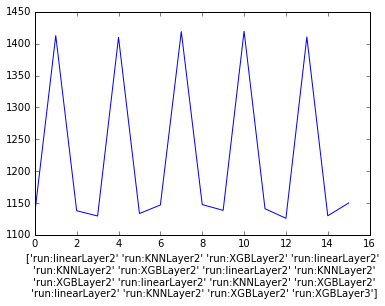

In [29]:

MAE_tracking_graph=np.array(MAE_tracking)

print(MAE_tracking_graph.T)

plt.plot(MAE_tracking_graph.T[1])
plt.xlabel(MAE_tracking_graph.T[0])

plt.show()

del MAE_tracking_graph

### Predict layer 1 on test 

In [29]:
x_layer2_test = []
start_time1 = time.time()
for i in range(len(regrList)): # for each of the regressions we use, fit/predict the data
    start_time = time.time()            
    estimator=skclone(regrList[i], safe=True)
    print(estimator)
    estimator.fit(x,y) # use the estimator from the training, but refit to the whole data set!
    curr_predict=estimator.predict(x_test_data)
    print("predict time:{}s".format(round((time.time()-start_time), 3) ))
    
    if x_layer2_test == []:
        x_layer2_test = np.array(curr_predict.copy())
    else:
        x_layer2_test = np.column_stack((x_layer2_test,curr_predict))

#XGB -- it doesn't fit the pattern of scikit, so do it seperatly
if use_xgb == True:

    dtrain = xgb.DMatrix(x, label=y)
    dtest = xgb.DMatrix(x_test_data)
    gbdt=xgb.train(xgb_params, dtrain, best_nrounds)

    # now do a prediction and spit out a score(MAE) that means something
    #start_time = time.time()
    curr_predict=gbdt.predict(dtest)
    x_layer2_test = np.column_stack((x_layer2_test,curr_predict))
    #print("Mean abs error: {:.2f}".format(np.mean(abs(cache[i+1] - y_test))))
    print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))

# add an avged column of all the runs
avg_column=np.mean(x_layer2_test, axis=1)
x_layer2_test=np.column_stack((x_layer2_test,avg_column))
print("AVG column added - length of new row: {}".format(len(x_layer2[0])))

print("Fold run time:{}s".format(round((time.time()-start_time1), 3) ))   

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
predict time:122.11s
Ridge(alpha=40, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
predict time:5.323s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


predict time:107.058s
XGB predict time:320.577s
AVG column added - length of new row: 6
Fold run time:448.015s


In [30]:
start_time = time.time()
# use the new clusters number to predict each locations cluster
print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
k_means =KMeans(n_clusters=80,n_jobs=12)
final_clusters=k_means.fit_predict(x_layer2_test)
print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
display("Clusters sample:",final_clusters[:15])

display("test-first 3",x_layer2_test[:3])
print("length of row: {}".format(len(x_layer2_test[0])))

x_layer2_test=np.column_stack((x_layer2_test,final_clusters))

display("test-first 3",x_layer2_test[:3])
print("length of row: {}".format(len(x_layer2_test[0])))
print("run time:{}s".format(round((time.time()-start_time), 3) ))   


redo kmeans with new cluster number from meanshift +1 to account for sampling...
kmeans round 2 time:38.092s


'Clusters sample:'

array([14, 30, 60, 27, 47, 22, 39, 43, 75,  5, 64, 43, 26, 67, 67], dtype=int32)

'test-first 3'

array([[ 7.53882837,  7.36421311,  7.56065475,  7.46098852,  7.48117119],
       [ 7.75194175,  7.60895517,  7.67783033,  7.67762709,  7.67908859],
       [ 9.05288467,  9.43546791,  8.97044867,  9.06942368,  9.13205623]])

length of row: 5


'test-first 3'

array([[  7.53882837,   7.36421311,   7.56065475,   7.46098852,
          7.48117119,  14.        ],
       [  7.75194175,   7.60895517,   7.67783033,   7.67762709,
          7.67908859,  30.        ],
       [  9.05288467,   9.43546791,   8.97044867,   9.06942368,
          9.13205623,  60.        ]])

length of row: 6
run time:38.105s


In [30]:
x_layer2_test=joblib.load(cachedir+'x_layer2_test_final.npy' ) 


### Layer 2 predictions!

In [31]:
#Linear
start_time = time.time()
layer3_predict_linear=layer2_Lin_regr.predict(x_layer2_test)
print("Linear predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = layer3_predict_linear

#KNeighborsRegressor
start_time = time.time()
layer3_predict_KNeighbors=layer2_KNN_regr.predict(x_layer2_test)
print("KNeighbors predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_predict_KNeighbors))  


# The XGB version of layer 2
dtest = xgb.DMatrix(x_layer2_test)
start_time = time.time()
layer3_gbdt_predict=layer2_gbdt.predict(dtest)
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_gbdt_predict))  


# ? average those weighted to XGB
start_time = time.time()

layer3_avg_predict=(layer3_predict_linear+layer3_predict_KNeighbors+layer3_gbdt_predict+layer3_gbdt_predict)/4
print("AVG predict time:{}s".format(round((time.time()-start_time), 3) ))    

x_layer3_test = np.column_stack((x_layer3_test,layer3_avg_predict))  



ValueError: shapes (125546,25) and (30,) not aligned: 25 (dim 1) != 30 (dim 0)

In [32]:
#spit out that good scoring linear result...
test_data['loss']=np.exp(layer3_predict_linear)-200


result=test_data[['id','loss',]]
output_fname="result_submission_stack_linear.csv"
display(writeData(result,output_fname))

['id,loss\n',
 '4,1542.75355317\n',
 '6,1995.66071952\n',
 '9,8494.12829359\n',
 '12,6138.85803957\n']

### Predict Layer 3

In [33]:
#the XGB version:
dtest = xgb.DMatrix(x_layer3_test)
test_data['loss']=np.exp(layer3_gbdt.predict(dtest))-200

result=test_data[['id','loss',]]
output_fname="result_submission_stack_xgb.csv"
display(writeData(result,output_fname))



['id,loss\n',
 '4,1786.10314941\n',
 '6,2006.43505859\n',
 '9,9415.99023438\n',
 '12,6253.11279297\n']

In [34]:
#let's have a look at the std of the result, as a cross check
print("result std:",result.std(axis=0))

('result std:', id      170098.328125
loss      1686.012573
dtype: float32)


# EOF 